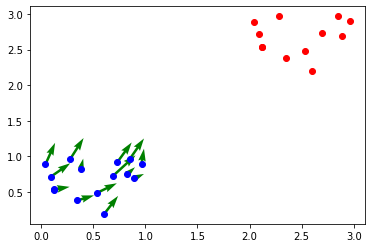

In [30]:
# Exclusivity loss
import torch
from pytorch3d.ops.knn import knn_gather, knn_points
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

pc1 = torch.rand(15, 3)
flow = torch.rand(15, 3, requires_grad=True)
# pc2 = torch.rand(12,3) + 1
pc2 = pc1[:12] + 2

plt.plot(pc1[:, 0], pc1[:, 1], 'bo')
plt.plot(pc2[:, 0], pc2[:, 1], 'ro')
plt.quiver(pc1[:, 0], pc1[:, 1], flow[:, 0].detach(), flow[:, 1].detach(), color='g')
# plt.show()

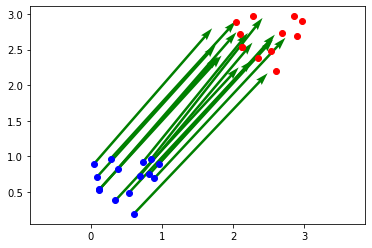

In [37]:
# dist, NN_ind, _ = knn_points((pc1+flow).unsqueeze(0), pc2.unsqueeze(0), K=1)

# todo for refinement?
# todo print("TODO: Loss precomputes all neighboors and separate losses will access it during current iteration")
# todo take a point cloud of the vehicle with false flow estimation and test on it only
# todo distance transform instead of NN for speed? paper on arxiv
# todo pouzivat labely pro statisticke insighty 
# todo metric as function of range to determine use cases for losses

def exclusivity_loss(flow, dist, NN_ind):
    
    max_ind = torch.max(NN_ind[0, :, 0]) + 1
    
    # vec = torch.zeros(max_ind, 3)
    # vec.scatter_reduce_(0, NN_ind[0].repeat(1,3), flow, reduce='min', include_self=False)
    # take only exclusive minimal NN distance
    vec_NN = torch.zeros(max_ind)
    # print(NN_ind[0, :, 0].shape, dist[0,:,0].shape) 
    # beware of dimensions of NN and distances
    vec_NN = vec_NN.scatter_reduce_(0, NN_ind[0, :, 0], dist[0, :, 0], reduce='amin', include_self=False)
    # print(vec_NN, '\n', dist[0, :, 0], '\n', NN_ind[0, :, 0])
    
    
    return vec_NN

optimizer = torch.optim.Adam([flow], lr=0.1)

for e in range(10):
    
    dist, NN_ind, _ = knn_points((pc1+flow).unsqueeze(0), pc2.unsqueeze(0), K=1)
    vec_NN = exclusivity_loss(flow, dist, NN_ind)
    
    # smoothness
    
    smooth_loss = ((flow - flow.mean(dim=0)) ** 2).mean()
    
    loss = vec_NN.mean() + 3 * smooth_loss
    # loss = dist.mean() + 3 * smooth_loss
    print(loss.item(), vec_NN.mean().item(), smooth_loss.item())
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    # visuals
    plt.clf()
    plt.plot(pc1[:, 0], pc1[:, 1], 'bo')
    plt.plot(pc2[:, 0], pc2[:, 1], 'ro')
    plt.quiver(pc1[:, 0], pc1[:, 1], flow[:, 0].detach(), flow[:, 1].detach(), color='g', units='xy', scale=1)
    plt.axis('equal')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.1)
    

In [22]:
# NN implementation by nearest interpolation
import torch
L, W, H = 10, 10, 10
voxel = torch.zeros((L, W, H))
voxel[2, 3, 4] = 1
voxel[L//2, W//2, 5] = 3

torch.nn.functional.interpolate(voxel, scale_factor=2, mode='nearest')
print(voxel.shape)
350 * 350 * 30

torch.Size([10, 10, 10])


3675000